In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
import category_encoders as ce


> **Funciones Graficas**

In [2]:

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    # Filtrar columnas con entre 2 y 49 valores únicos
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    
    nRow, nCol = df.shape
    columnNames = list(df)
    # Asegurar que nGraphRow sea un entero
    nGraphRow = int(np.ceil((nCol + nGraphPerRow - 1) / nGraphPerRow))
    
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        # Si la primera entrada de la columna no es numérica, hacemos gráfico de barras
        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [3]:

def plotCorrelationMatrix(df, graphWidth):
    # Eliminar columnas con NaN
    df = df.dropna(axis='columns')
    # Conservar solo columnas con más de 1 valor único
    df = df[[col for col in df if df[col].nunique() > 1]]
    # Filtrar únicamente las columnas numéricas para calcular la correlación
    df_numeric = df.select_dtypes(include=[np.number])
    if df_numeric.shape[1] < 2:
        print("No se puede generar una matriz de correlación (menos de 2 columnas numéricas).")
        return
    corr = df_numeric.corr()
    plt.figure(figsize=(graphWidth, graphWidth))
    plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar()
    plt.title('Correlation Matrix', y=1.15)
    plt.show()


In [4]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number])  # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns with more than 1 unique value
    columnNames = list(df)
    if len(columnNames) > 10:  # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2),
                          xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

## Cargamos y unimos los dataframes 

In [5]:
df_final_1 = pd.read_csv('data1.csv')
df_final_2 = pd.read_csv('data2.csv')
df_final_target = pd.read_csv('objetivo.csv')

# Une los DataFrames de entrenamiento y combina con el target
df_final = pd.concat([df_final_1, df_final_2], axis=0)
df_final = pd.merge(df_final, df_final_target, on="id")

In [6]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

**- Conclusiones: se deben convertir algunas columnas y revisar los nulos**
- [date_recorded] es tipo object y deberiamos convertirl en datetime

- status_group es nuestra columna objetivo debe ser cambiada a numerica

- cuando se haga el preprocesado se deben convertir todas a numerico

- scheme_name tiene muchos nulos seberia eliminar

### Observamos que hay varias columnas con muchos nulos, especialmente scheme_name, debriamos borrar esta

In [7]:
df_final.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

- hay varias columans con muchos nulos vamos a probar eliminando las que mas nulos tienen

- Eliminar [ funder ,installer ,public_meeting ,scheme_management ,permit]

In [8]:
df_final.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


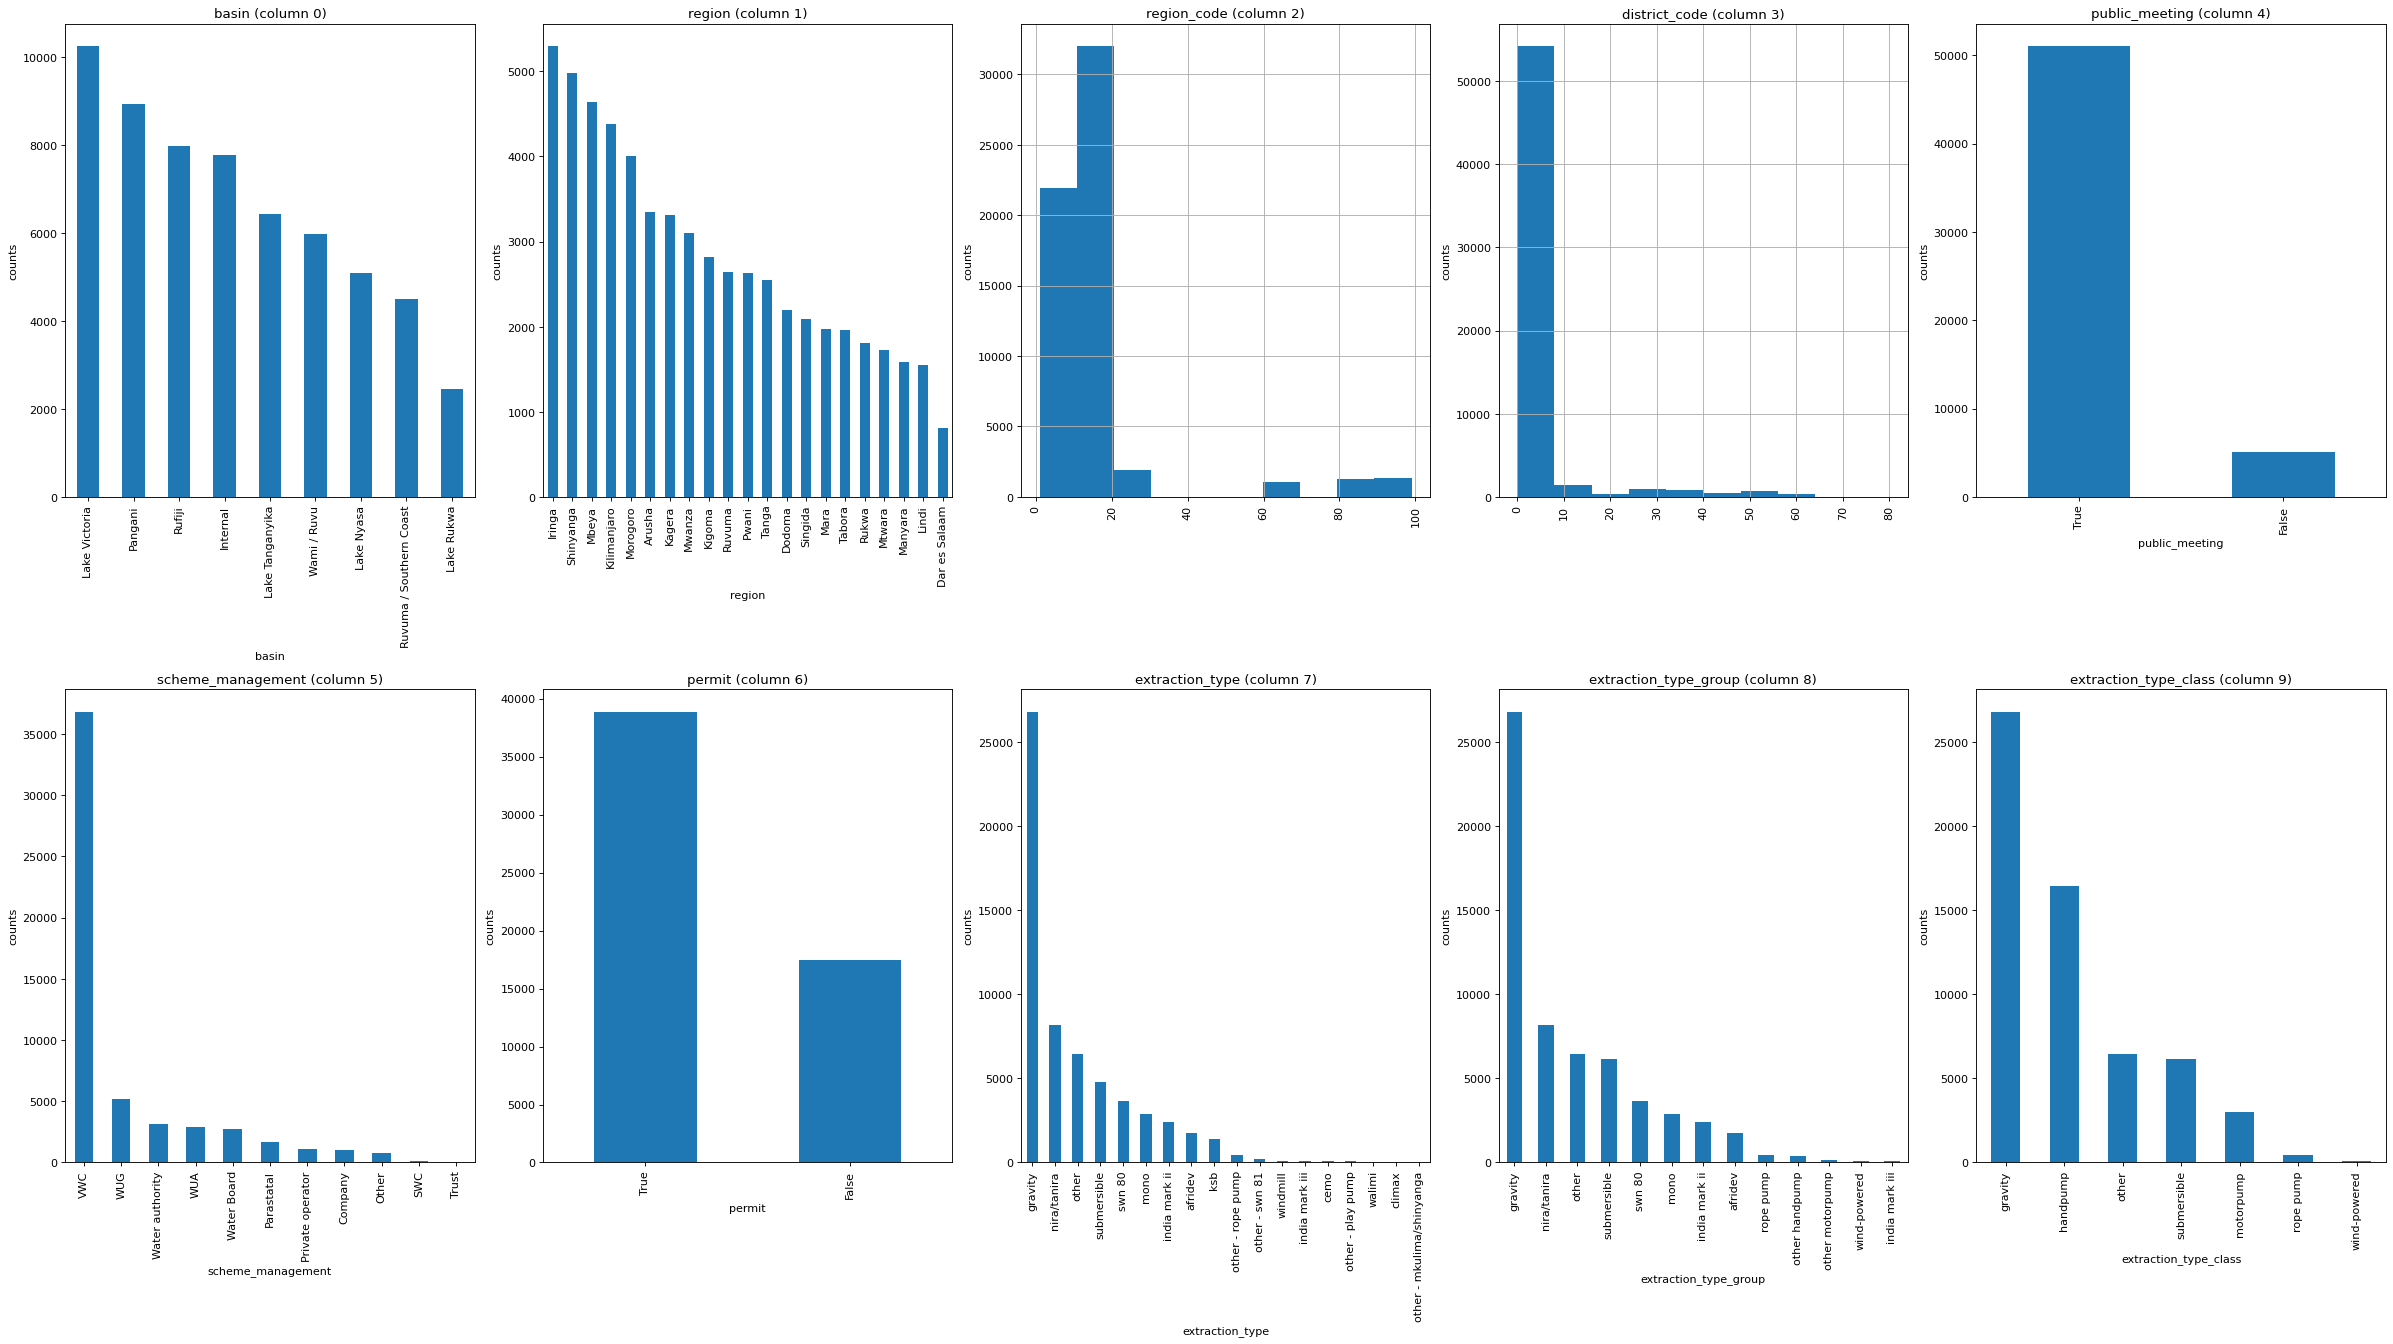

In [9]:
plotPerColumnDistribution(df_final, 10, 5)

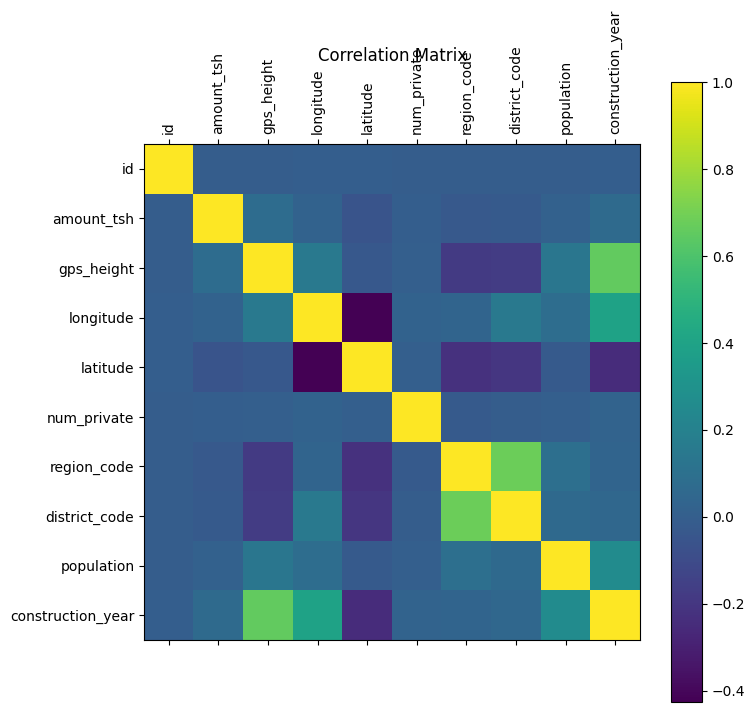

In [10]:
plotCorrelationMatrix(df_final, 8)

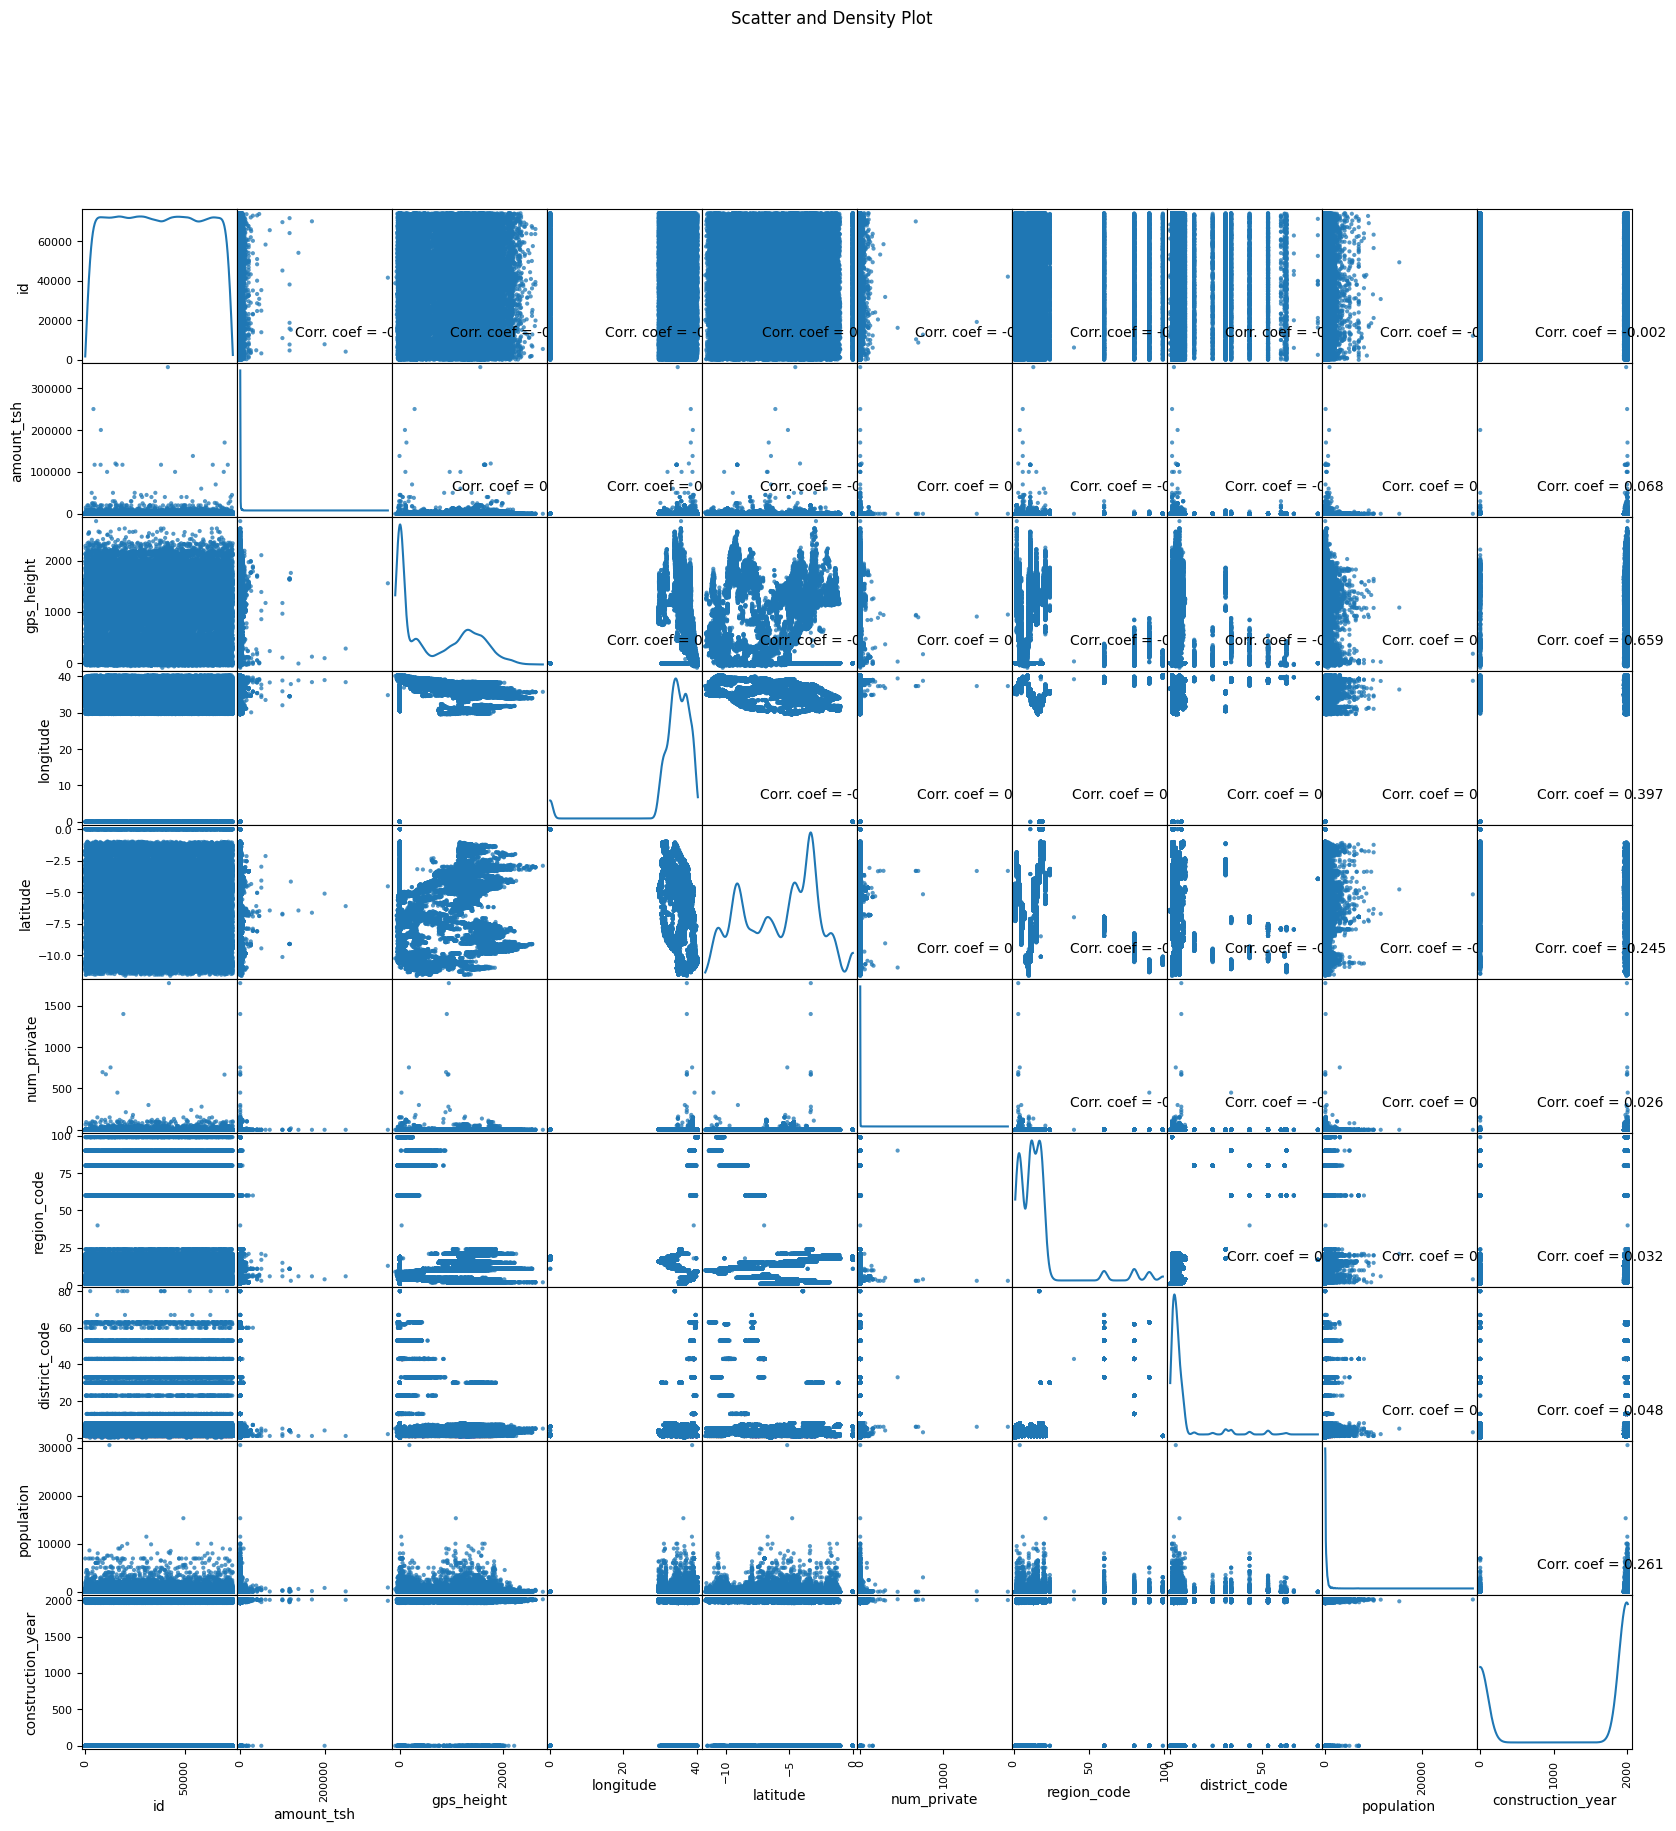

In [11]:
plotScatterMatrix(df_final, 20, 10)

# **Limpiar Datos**

In [12]:
df_clean=df_final.copy()

In [13]:
df_clean.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [14]:
df_clean.status_group.map({'non functional':0,'functional':1,'functional needs repair':2})

0        1
1        1
2        1
3        0
4        1
        ..
59395    1
59396    1
59397    1
59398    1
59399    1
Name: status_group, Length: 59400, dtype: int64

In [15]:
df_clean.status_group=df_clean.status_group.map({'non functional':0,'functional':1,'functional needs repair':2})

In [16]:
columns=df_clean.columns
drops=[]

for col in columns:
    value=round((df_clean[col].isna().sum()/df_clean.shape[0])*100,2)
    if  value >0 and value <=7: 
        drops.append(col)

print(drops)
for col in drops:
    df_clean.dropna(subset=[col],inplace=True) #to drop rows 

['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'permit']


In [17]:
round((df_clean.isna().sum()/df_clean.shape[0])*100,2)

id                        0.00
amount_tsh                0.00
date_recorded             0.00
funder                    0.00
gps_height                0.00
installer                 0.00
longitude                 0.00
latitude                  0.00
wpt_name                  0.00
num_private               0.00
basin                     0.00
subvillage                0.00
region                    0.00
region_code               0.00
district_code             0.00
lga                       0.00
ward                      0.00
population                0.00
public_meeting            0.00
recorded_by               0.00
scheme_management         0.00
scheme_name              43.73
permit                    0.00
construction_year         0.00
extraction_type           0.00
extraction_type_group     0.00
extraction_type_class     0.00
management                0.00
management_group          0.00
payment                   0.00
payment_type              0.00
water_quality             0.00
quality_

In [18]:
len(df_clean.scheme_name.unique())

2577

In [19]:
df_clean.scheme_name.value_counts()

scheme_name
Borehole                       543
Chalinze wate                  404
Ngana water supplied scheme    270
wanging'ombe water supply s    261
wanging'ombe supply scheme     233
                              ... 
Bl Aziz water supply             1
Mtikanga supply scheme           1
Mnazi mmoja                      1
Handeni Trunk Maini(             1
Mtawanya                         1
Name: count, Length: 2576, dtype: int64

En un principio elimine esta variable pero al probar metiendola en un segundo intento mejoro un poco asi que voy a imputar los valores nulos mas adelante

In [20]:
df_clean["date_recorded"] = pd.to_datetime(df_clean["date_recorded"])
df_clean.insert(loc=3,column='recorded_year',value=df_clean.date_recorded.dt.year )#year
df_clean.insert(loc=4,column='recorded_month',value=df_clean.date_recorded.dt.month )# month
df_clean.insert(loc=5,column='recorded_day',value=df_clean.date_recorded.dt.day)# day

# **EDA**

In [21]:
df_eda=df_clean.copy()

In [22]:
df_eda.drop("id",axis=1,inplace=True)

In [23]:
categorical=df_eda.select_dtypes("O").columns
numerical =df_eda.select_dtypes(exclude="O").columns

In [24]:
df_eda[numerical].describe().round(2)

,amount_tsh,date_recorded,recorded_year,recorded_month,recorded_day,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
count,48287.00,48287,48287.00,48287.00,48287.00,48287.00,48287.00,48287.00,48287.00,48287.00,48287.00,48287.00,48287.00,48287.00
mean,360.42,2012-03-21 03:42:55.028475392,2011.90,4.33,15.61,701.51,34.21,-5.70,0.55,14.79,5.75,176.69,1342.76,0.69
min,0.00,2002-10-14 00:00:00,2002.00,1.00,1.00,-90.00,0.00,-11.65,0.00,1.00,0.00,0.00,0.00,0.00
25%,0.00,2011-03-28 00:00:00,2011.00,2.00,8.00,0.00,33.04,-8.25,0.00,5.00,2.00,0.00,0.00,0.00
50%,0.00,2012-10-03 00:00:00,2012.00,3.00,16.00,463.00,35.21,-4.99,0.00,12.00,3.00,30.00,1987.00,1.00
75%,50.00,2013-02-09 00:00:00,2013.00,7.00,23.00,1335.00,37.36,-3.33,0.00,17.00,5.00,200.00,2005.00,1.00
max,250000.00,2013-12-03 00:00:00,2013.00,12.00,31.00,2770.00,40.32,-0.00,1776.00,99.00,80.00,30500.00,2013.00,2.00
std,2828.47,NaN,0.96,3.00,8.70,698.81,6.33,2.87,13.29,17.24,9.70,472.51,937.15,0.60


**Notas: **

1) Estan raros los cuartiles de  amount_tsh , num_private , population

2) Usar correlation 

In [25]:
df_eda['amount_tsh'].quantile([0.50,0.70,0.80,0.90,0.95,0.99,0.990,.995,.999,1]).to_frame().T


,0.500,0.700,0.800,0.900,0.950,0.990,0.990,0.995,0.999,1.000
amount_tsh,0.0,20.0,100.0,500.0,2000.0,5000.0,5000.0,8000.0,20000.0,250000.0


**Notas: **

> El 95% de los valores estan por debajo de 8000

In [26]:
df_eda.drop(df_eda[df_eda.amount_tsh>=8000].index,inplace=True)

<Axes: xlabel='num_private', ylabel='Count'>

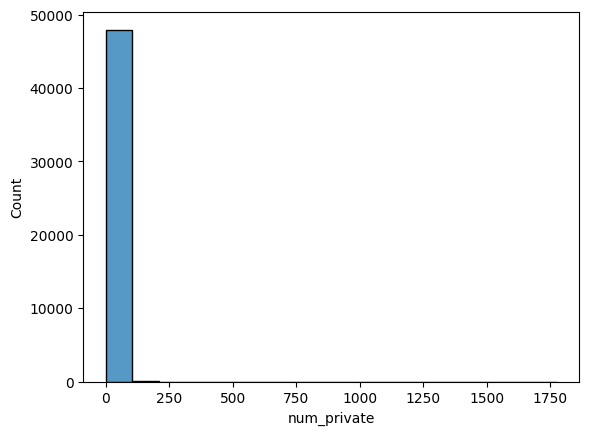

In [27]:
sns.histplot(x=df_eda['num_private'])

In [28]:
df_eda['num_private'].quantile([0.95,0.99,0.990,.995,.999,1]).to_frame().T

,0.950,0.990,0.990,0.995,0.999,1.000
num_private,0.0,6.0,6.0,32.0,93.0,1776.0


In [29]:
df_eda.drop(df_eda[df_eda['num_private']>93].index,inplace=True)

In [30]:
px.histogram(x=df_eda['population'])

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'bingroup': 'x',
              'hovertemplate': 'x=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'histogram',
              'x': {'bdata': ('bQD6ADoAAQAAAAAAWQH6AAAAAQAAAM' ... 'QB3AWWANIAAAAAAFkAfQA4AAAAlgA='),
                    'dtype': 'i2'},
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'count'}}}
})

In [38]:
df_eda['population'].quantile([0,0.40,0.50,0.70,0.80,0.90,0.95,0.99,0.990,.995,.999,1]).to_frame().T

,0.000,0.400,0.500,0.700,0.800,0.900,0.950,0.990,0.990,0.995,0.999,1.000
population,0.0,1.0,30.0,150.0,250.0,450.0,650.0,1650.0,1650.0,2500.0,5000.0,6800.0


In [39]:
df_eda.drop(df_eda[df_eda['population']>df_eda['population'].quantile(0.999)].index,inplace=True)

# **preprocessing**

### Se hace la primera transformacion para calcualr la antiguedad del punto de agua y ver si es nuevo, viejo,antiguo o media y asi saber con mas presicion si por ejemplo llos puntos de agua contruidos en ciertos años tienen mas fallas

In [33]:
df_pre = df_eda.copy()

In [34]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47914 entries, 0 to 59399
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   amount_tsh             47914 non-null  float64       
 1   date_recorded          47914 non-null  datetime64[ns]
 2   recorded_year          47914 non-null  int32         
 3   recorded_month         47914 non-null  int32         
 4   recorded_day           47914 non-null  int32         
 5   funder                 47914 non-null  object        
 6   gps_height             47914 non-null  int64         
 7   installer              47914 non-null  object        
 8   longitude              47914 non-null  float64       
 9   latitude               47914 non-null  float64       
 10  wpt_name               47912 non-null  object        
 11  num_private            47914 non-null  int64         
 12  basin                  47914 non-null  object        
 13  subvil

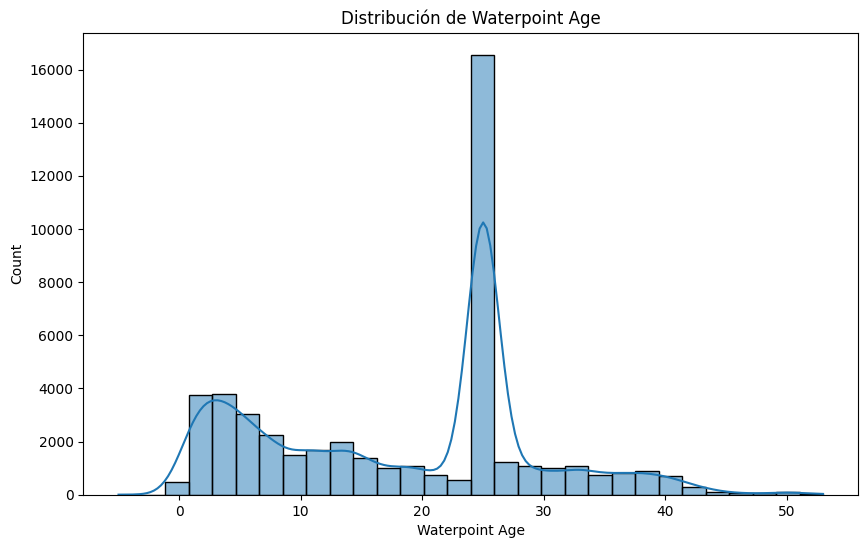

In [35]:
df_pre["waterpoint_age"] = df_pre["recorded_year"] - df_pre["construction_year"]
df_pre.loc[df_pre["construction_year"] == 0, "waterpoint_age"] = df_pre["waterpoint_age"].median()
plt.figure(figsize=(10, 6))
sns.histplot(df_pre['waterpoint_age'], bins=30, kde=True)
plt.xlabel("Waterpoint Age")
plt.title("Distribución de Waterpoint Age")
plt.show()

### Se puede observar que del resultado de la operacion hay datos negativo, esto se puede deber que el año de contruccion era 0 y al llenarlo con la mediana hizo que pasara esto

### Ahora con este resultado podemos clasificar este nuevo datos en baja,media y alta segun los años de la ultima visita

In [36]:
# Definir los bins y las etiquetas
bins = [-np.inf, 0, 8, 26, 53]
labels = ['Negativo/Inconsistente', 'Muy Baja', 'Baja', 'Alta']

# Supongamos que df_final es tu DataFrame y 'waterpoint_age' es la variable a categorizar
df_pre['waterpoint_age_category'] = pd.cut(df_pre['waterpoint_age'], bins=bins, labels=labels, include_lowest=True)

# Ver la distribución de las categorías
print(df_pre['waterpoint_age_category'].value_counts())

# eliminnamos las columnas que no se usarán
df_pre.drop(columns=['recorded_year', 'recorded_month', 'recorded_day', 'construction_year','waterpoint_age'], inplace=True)

waterpoint_age_category
Baja                      27020
Muy Baja                  12833
Alta                       7594
Negativo/Inconsistente      467
Name: count, dtype: int64


### La segunda transformacion que podemos realizar en agrupar puntos de agua por proximidad esto nos va a permitir saber si los puntos de agua mas alejados del centro tienen mas o menos problemas

### para realizar esta transformacion vamos a usar K-Means para agrupar los puntos por 10 regiones aproximadas

In [40]:
from sklearn.cluster import KMeans
from geopy.distance import geodesic

kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
df_pre["location_cluster"] = kmeans.fit_predict(df_pre[["longitude", "latitude"]])
# Crear un diccionario con el centro de cada región
region_centers = df_pre.groupby("region")[["latitude", "longitude"]].median()

# Función para calcular la distancia geográfica
def calcular_distancia(row):
    centro = region_centers.loc[row["region"]]
    return geodesic((row["latitude"], row["longitude"]), (centro["latitude"], centro["longitude"])).km


# Aplicar la función
df_pre["distance_to_region_center"] = df_pre.apply(calcular_distancia, axis=1)
print(df_pre["distance_to_region_center"].describe())

count    47914.000000
mean       167.503999
std        600.185555
min          0.128756
25%         29.606680
50%         57.307299
75%         96.329400
max       3741.189445
Name: distance_to_region_center, dtype: float64


### Con esta distancia puedo categorizar la lejania en cercano(1), mediano(2), lejano(3)

In [41]:
df_pre['log_distance'] = np.log1p(df_pre['distance_to_region_center'])
df_pre['log_distance_categoria'] = pd.qcut(df_pre['log_distance'], q=4, 
                                        labels=['Muy corta', 'Corta', 'Media', 'Larga'])

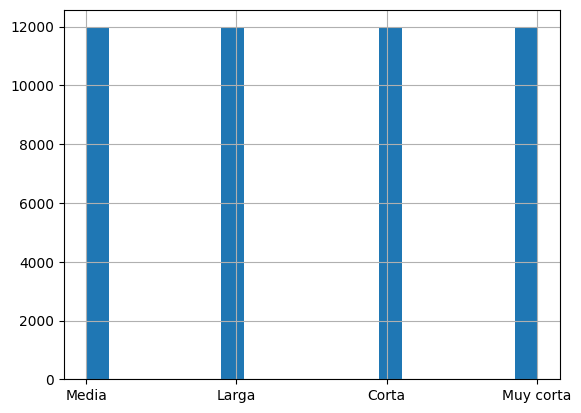

In [42]:
df_pre['log_distance_categoria'].hist(bins=20)
plt.show()
df_pre.drop(columns=['distance_to_region_center', 'log_distance','longitude', 'latitude','region'], inplace=True)

In [43]:
df_pre.status_group.value_counts(normalize=True)*100 # as precentage

status_group
1    54.698001
0    38.030638
2     7.271361
Name: proportion, dtype: float64

In [44]:
X=df_pre.drop('status_group',axis=1)
y=df_pre.status_group


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)#to handling imbalnce probelm


In [46]:
y_train.value_counts(normalize=True)*100
y_test.value_counts(normalize=True)*100

status_group
1    55.297391
0    37.648696
2     7.053913
Name: proportion, dtype: float64

In [47]:
df_pre.drop(columns=['date_recorded'], inplace=True)

In [48]:
cat_cols = df_pre.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = df_pre.select_dtypes(exclude=["object", "category"]).columns.drop('status_group').tolist()

In [49]:
cat_cols

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'waterpoint_age_category',
 'log_distance_categoria']

In [50]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47914 entries, 0 to 59399
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   amount_tsh               47914 non-null  float64 
 1   funder                   47914 non-null  object  
 2   gps_height               47914 non-null  int64   
 3   installer                47914 non-null  object  
 4   wpt_name                 47912 non-null  object  
 5   num_private              47914 non-null  int64   
 6   basin                    47914 non-null  object  
 7   subvillage               47914 non-null  object  
 8   region_code              47914 non-null  int64   
 9   district_code            47914 non-null  int64   
 10  lga                      47914 non-null  object  
 11  ward                     47914 non-null  object  
 12  population               47914 non-null  int64   
 13  public_meeting           47914 non-null  object  
 14  recorded_by

In [51]:
binary = BinaryEncoder()
scaler = StandardScaler()


preprocessor = ColumnTransformer(
    [
        ('encoding' , binary , cat_cols ) ,
        ('scaling' , scaler , num_cols),
    ]
)

X_train_prep=preprocessor.fit_transform(X_train)
X_test_prep=preprocessor.transform(X_test)

In [52]:
yy_train=y_train.reset_index().drop("index",axis=1)
yy_train=yy_train.reset_index()
yy_train

,index,status_group
0,0,1
1,1,1
2,2,0
3,3,1
4,4,1
...,...,...
33534,33534,0
33535,33535,1
33536,33536,0
33537,33537,0


In [53]:
yy_test=y_test.reset_index().drop("index",axis=1)
yy_test=yy_test.reset_index()
yy_test

,index,status_group
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
...,...,...
14370,14370,0
14371,14371,0
14372,14372,0
14373,14373,0


In [54]:
df_train=pd.DataFrame(X_train_prep,columns=preprocessor.get_feature_names_out()).reset_index()
df_test=pd.DataFrame(X_test_prep,columns=preprocessor.get_feature_names_out()).reset_index()

In [55]:
df_test=df_test.merge(yy_test)
df_test

,index,encoding__funder_0,encoding__funder_1,encoding__funder_2,encoding__funder_3,encoding__funder_4,encoding__funder_5,encoding__funder_6,encoding__funder_7,encoding__funder_8,...,encoding__log_distance_categoria_1,encoding__log_distance_categoria_2,scaling__amount_tsh,scaling__gps_height,scaling__num_private,scaling__region_code,scaling__district_code,scaling__population,scaling__location_cluster,status_group
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,-0.311211,-1.001810,-0.081969,0.184349,-0.491255,-0.430585,-1.753975,1
1,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,-0.311211,1.226598,-0.081969,0.358379,-0.491255,-0.096383,-0.625083,1
2,2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,-0.311211,-1.001810,-0.081969,0.242359,-0.182581,-0.430585,0.880107,1
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.311211,0.656607,-0.081969,0.010319,-0.491255,-0.044967,0.127512,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,-0.311211,0.630829,-0.081969,0.300369,-0.182581,0.726269,0.880107,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14370,14370,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,-0.311211,-0.994649,-0.081969,-0.511770,-0.491255,1.111887,0.503809,0
14371,14371,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-0.311211,1.611844,-0.081969,0.010319,-0.388364,0.597729,-0.248786,0
14372,14372,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,-0.311211,0.811278,-0.081969,-0.685800,0.126093,-0.428015,-0.625083,0
14373,14373,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,-0.246333,1.594658,-0.081969,0.010319,-0.182581,2.397280,-0.248786,0


In [56]:
df_train=df_train.merge(yy_train)
df_train

,index,encoding__funder_0,encoding__funder_1,encoding__funder_2,encoding__funder_3,encoding__funder_4,encoding__funder_5,encoding__funder_6,encoding__funder_7,encoding__funder_8,...,encoding__log_distance_categoria_1,encoding__log_distance_categoria_2,scaling__amount_tsh,scaling__gps_height,scaling__num_private,scaling__region_code,scaling__district_code,scaling__population,scaling__location_cluster,status_group
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.051701,-0.122477,-0.081969,-0.685800,-0.285472,-0.302046,-0.625083,1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.078054,-0.397447,-0.081969,-0.569780,-0.491255,0.854808,1.632701,1
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.311211,-0.854300,-0.081969,-0.511770,-0.285472,1.626044,0.503809,0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,-0.181456,0.189730,-0.081969,-0.279731,-0.285472,-0.029543,-1.001380,1
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,-0.311211,-1.001810,-0.081969,-0.047691,-0.182581,-0.430585,0.127512,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33534,33534,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,1.0,-0.311211,-0.593650,-0.081969,-0.511770,-0.491255,2.140202,0.503809,0
33535,33535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,-0.246333,-0.827089,0.181486,2.620766,4.859096,-0.428015,0.503809,1
33536,33536,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,-0.311211,-0.736864,-0.081969,-0.337741,-0.182581,-0.428015,1.256404,0
33537,33537,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,-0.311211,1.640487,-0.081969,0.010319,-0.285472,-0.428015,-0.248786,0


In [57]:
df_train.drop("index",axis=1,inplace=True)
df_test.drop("index",axis=1,inplace=True)

In [58]:
#save
df_train.to_csv("df_train.csv",index=False)
df_test.to_csv("df_test.csv",index=False)

In [59]:
#Baics model
from sklearn.linear_model import LogisticRegression

basic=LogisticRegression()
basic.fit(X_train_prep,y_train)

/Users/giovannicapote/Documents/Master/Data Science/Tarea/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [ ]:
print(basic.score(X_test_prep,y_test))

0.7347478260869565


: 

In [ ]:
#using polynomial and hyperparameter

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
#first make pipeline with model and PolynomialFeatures together
pipe=Pipeline(steps=[
                    ("ploy",PolynomialFeatures()),
                    ("log",LogisticRegression())
                    ])
#all possible paramter to select hyperparameter with best one
parameter_log={"ploy__degree":[2,3,4],
                "log__tol":[0.001,0.0001,0.00001],
               "log__C":[1,2,3,4]}

log=RandomizedSearchCV(estimator=pipe,param_distributions=parameter_log,cv=3)

#fit
log.fit(X_train_prep,y_train)


In [ ]:
for col in ['waterpoint_age_category', 'log_distance_categoria']:
    if col in X.columns:
        # Convertir a string si no lo son ya
        X[col] = X[col].astype(str)
        # Si la columna no estaba en la lista, la agregamos
        if col not in cat_cols:
            cat_cols.append(col)
            
threshold = 10  # Número mínimo de ocurrencias
for col in cat_cols:
    counts = X[col].value_counts()
    # Si la categoría aparece menos veces que el umbral, se reemplaza por 'Otros'
    mask = X[col].isin(counts[counts < threshold].index)
    X[col] = np.where(mask, 'Otros', X[col])

# Verificar la cantidad de categorías después de reemplazar
encoder = ce.BinaryEncoder(cols=cat_cols)
X_encoder = encoder.fit_transform(X)


: 

: 

In [ ]:
X_encoder.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47914 entries, 0 to 59399
Columns: 144 entries, amount_tsh to log_distance_categoria_2
dtypes: datetime64[ns](1), float64(1), int32(1), int64(141)
memory usage: 52.8 MB


: 

In [ ]:
# 8. Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoder, y, test_size=0.2, random_state=42
)

: 

In [ ]:
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
# 9. Entrenar el modelo con RandomForestClassifier
modelo.fit(X_train, y_train)

# 10. Predecir sobre el conjunto de prueba
y_pred = modelo.predict(X_test)

# 11. Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# 12. Mostrar resultados
print(f"\n✅ Accuracy del modelo: {accuracy:.2%}\n")
print("📊 Clasificación por clase:\n")
print(report)
print("\n🧩 Matriz de confusión:\n")
print(conf_matrix)

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>)

: 

In [ ]:
# Extraer los nombres de las features del preprocesador
feature_names = modelo.named_steps['preprocessor'].get_feature_names_out()

# Obtener las importancias del clasificador
importances = modelo.named_steps['classifier'].feature_importances_

# Crear un DataFrame para visualizar la importancia de cada feature
feat_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Importancia de las 10 características principales:")
print(feat_importances.head(20))

AttributeError: 'RandomForestClassifier' object has no attribute 'named_steps'

: 